In [1]:
import pandas as pd, os, csv, preprocessing, datetime as dt, matplotlib.pyplot as plt, numpy as np

# Read in Large Text File

In [2]:
iter_csv = pd.read_csv('../data/itcont.txt', iterator=True, chunksize=100000, header=None, 
                       error_bad_lines=False, sep='|', parse_dates=[13])
df = pd.concat([chunk[chunk[3] == 'P2020'].iloc[:,:-6] for chunk in iter_csv])
headers = pd.read_csv('../data/indiv_header_file.csv')
df.columns = headers.iloc[:,:-6].columns

/home/joe/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (10,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/joe/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (5,10,15) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/joe/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/joe/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (10,16,18) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/home/joe/anaconda3/lib/python3.7/site-package

## Creating Maps bc FEC data is organized like shit
The individual contribution dataset contains only reference to committees. These maps help connect committees to candidates

In [3]:
cand_id_to_name = {}
committee_to_cand = {}
with open('../data/cn.txt') as csvfile:
    data = csv.reader(csvfile, delimiter='|')
    for row in data:
        cand_id_to_name[row[0]] = row[1]
        
with open('../data/ccl.txt') as csvfile:
    data = csv.reader(csvfile, delimiter='|')
    for row in data:
        committee_to_cand[row[3]] = cand_id_to_name.get(row[0], 'unknown')

In [4]:
df['cand_nm'] = df.CMTE_ID.apply(lambda x: committee_to_cand.get(x, 'Unknown'))

In [6]:
cands = ['BIDEN, JOSEPH R JR', 'WARREN, ELIZABETH ', 'SANDERS, BERNARD', 'BUTTIGIEG, PETE',
 'HARRIS, KAMALA D.', 'BOOKER, CORY A.', 'KLOBUCHAR, AMY J.', 'YANG, ANDREW',
 'RYAN, TIMOTHY J.', 'BULLOCK, STEVE', 'CASTRO, JULIÁN', 'DELANEY, JOHN K.',
 'GABBARD, TULSI', 'STEYER, TOM', 'SESTAK, JOSEPH A. JR.', 'WILLIAMSON, MARIANNE ',
 'BENNET, MICHAEL F.', 'TRUMP, DONALD J.', 'WALSH, JOE', 'WELD, WILLIAM FLOYD (BILL)',
 'DE BLASIO, BILL', 'INSLEE, JAY R', 'GILLIBRAND, KIRSTEN ', 'GRAVEL, MAURICE ROBERT',
 'SWALWELL, ERIC MICHAEL', 'HICKENLOOPER, JOHN W.', 'MOULTON, SETH', 'OJEDA, RICHARD NEECE II', 'RYAN, TIMOTHY J.']

In [7]:
# filter for presidential candidates / relevant info
df = df[df.cand_nm.isin(set(cands))].iloc[:,7:]
# change column names
old_col_names = ['contbr_nm', 'contbr_city', 'contbr_st', 'contbr_zip',
                 'contbr_employer', 'contbr_occupation', 'contb_receipt_dt', 
                 'contb_receipt_amt', 'cand_nm']
df.columns=old_col_names

# convert dates to comparable datetime objects
df['contb_receipt_dt'] = df.copy().contb_receipt_dt.apply(lambda x: dt.datetime.strptime(str(x), '%m%d%Y'))


In [8]:
# preprocessing
df = preprocessing.filter(df)
df = preprocessing.add_fields(df)
df = preprocessing.clean_employers(df)
df = preprocessing.clean_occupations(df)

# Data Analysis

In [9]:
# define relevant candidates
candidates = ['BIDEN, JOSEPH R JR', 'WARREN, ELIZABETH ', 'SANDERS, BERNARD', 'BUTTIGIEG, PETE',
 'HARRIS, KAMALA D.', 'BOOKER, CORY A.', 'KLOBUCHAR, AMY J.', 'YANG, ANDREW',
 'GABBARD, TULSI', 'STEYER, TOM', 'WILLIAMSON, MARIANNE ']

In [10]:
occupation_counts = df.groupby('contbr_occupation').count().cand_nm
jobs_of_interest = occupation_counts[occupation_counts > 1000].index
jobs_of_interest

Index(['ACCOUNTANT', 'ACTOR', 'ADMINISTRATIVE ASSISTANT', 'ADMINISTRATOR',
       'ANALYST', 'ARCHITECT', 'ARTIST', 'ATTORNEY', 'BANKER', 'BOOKKEEPER',
       'CARPENTER', 'CEO', 'CLERK', 'CONSTRUCTION', 'CONSULTANT', 'CPA',
       'CUSTOMER SERVICE', 'DENTIST', 'DESIGNER', 'DIRECTOR', 'DRIVER',
       'EDITOR', 'EDUCATION', 'EDUCATOR', 'ELECTRICIAN', 'ENGINEER',
       'EXECUTIVE', 'EXECUTIVE ASSISTANT', 'EXECUTIVE DIRECTOR', 'FARMER',
       'FINANCE', 'GRAPHIC DESIGNER', 'HOMEMAKER', 'INSTRUCTOR', 'INVESTOR',
       'IT', 'LAWYER', 'LIBRARIAN', 'MANAGER', 'MARKETING',
       'MASSAGE THERAPIST', 'MUSICIAN', 'NONE', 'NOT EMPLOYED', 'NURSE',
       'NURSE PRACTITIONER', 'OFFICE MANAGER', 'PARALEGAL', 'PARTNER',
       'PHARMACIST', 'PHOTOGRAPHER', 'PHYSICIAN', 'PILOT', 'PRESIDENT',
       'PRODUCER', 'PRODUCT MANAGER', 'PROFESSOR', 'PROGRAM MANAGER',
       'PROJECT MANAGER', 'PSYCHOLOGIST', 'PSYCHOTHERAPIST', 'REAL ESTATE',
       'RETAIL', 'RETIRED', 'SALES', 'SCIENTIST', 'SELF EMPL

In [11]:
def cluster_professions(amount_thresh=1000, count=False, clusters=4, pca_components=2):
    #occupation_counts = df.groupby('contbr_occupation').count().cand_nm
    #jobs_of_interest = occupation_counts[occupation_counts > amount_thresh].index
    global jobs_of_interest
    # creating dataset of counts
    counts = {}
    for cand in candidates:
        temp = df[df['cand_nm'] == cand]
        temp = temp[temp['contb_receipt_dt'] > pd.datetime(2019,1,1)]
        temp = temp[temp.contbr_occupation.isin(jobs_of_interest)]

        if count:
            counts[cand] = temp.groupby('contbr_occupation').count().contb_receipt_amt
        else:
            counts[cand] = temp.groupby('contbr_occupation').sum().contb_receipt_amt


    # I forget what this does
    new = pd.DataFrame([0]*len(jobs_of_interest))
    new.index = jobs_of_interest
    for cand, count in counts.items():
        try:
            new[cand] = count#(count - count.mean())/(count.max()-count.min())
        except:
            new.combine_first(count)#(count - count.mean())/(count.max()-count.min()))

    # normalize matrix (all rows sum to 1)
    res = new.div(new.sum(axis=1), axis=0).fillna(0)
    global global_temp
    global_temp = res
    mat = res.values
    from sklearn.cluster import KMeans

    
    km = KMeans(n_clusters=clusters)
    km.fit(mat)
    labels = km.labels_
    res['label'] = labels
    res = res.join(occupation_counts)
    results = pd.DataFrame([labels]).T
    results.index = res.index
    
    cluster_labels = {0: 0, 1:1, 2:2, 3:3}
    '''
    for i in range(clusters):
        if 'MECHANIC' in res[res.label == i].index:
            cluster_labels[i] = 'Blue Collar'
        if 'ATTORNEY' in res[res.label == i].index:
            cluster_labels[i] = 'Wealthy'
        if 'NURSE' in  res[res.label == i].index:
            cluster_labels[i] = 'Middle Class / White Collar'
        if 'MANAGER' in  res[res.label == i].index:
            cluster_labels[i] = 'Educated'
    '''
    for i in range(clusters):
        print(f' jobs with most contributors for cluster {i}: ')
        print(', '.join(res[res.label == i].sort_values('cand_nm', ascending=False).head(10).index))
        
    average_contributions = res.drop(columns='cand_nm').groupby('label').mean()
    print(average_contributions)
    print('Showing distribution of donations across candidates for each cluster')
    plt.figure(figsize=(16,16))
    fig, ax = plt.subplots(2, 2, figsize=(16,16))
    plt.rcParams.update({'font.size': 28})
    for i in range(len(average_contributions)):
        row, col = int(i/2), i%2
        ax[row, col].set_title(f'{cluster_labels[i] }')#' Cluster Distribution')
        draw_labels = []
        for value, column in zip(average_contributions.iloc[i].values, average_contributions.columns):
            if value < .05:
                draw_labels.append('')
            else:
                draw_labels.append(column.split(',')[0])
        patches, texts = ax[row, col].pie(average_contributions.iloc[i].values, labels=draw_labels)#average_contributions.columns)
    #plt.legend(patches, average_contributions.columns)
    plt.show()
    print('Showing distribution of jobs across clusters')
    plt.hist(labels)
    plt.ylabel('Count')
    plt.xlabel('Cluster')
    plt.title('Distribution of jobs across clusters')
    plt.show()
    
    # PCA

    from sklearn.decomposition import PCA

    pca = PCA(n_components=pca_components)

    covar_mat = PCA(n_components=len(res.columns)-2)
    covar_mat.fit(res.drop(columns=['label']))
    variance = covar_mat.explained_variance_ratio_
    var = np.cumsum(np.round(covar_mat.explained_variance_ratio_, decimals=3)*100)
    
    plt.plot(var)
    plt.title('Variance Explained by # Components')
    plt.xlabel('# of Components')
    plt.ylabel('Variance Explained')
    plt.show()
    print(var)
    principalComponents = pca.fit_transform(res.drop(columns=['label', 'cand_nm']))

    principalDataframe = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
    
    global component_map
    component_map = pd.DataFrame(pca.components_, columns=[res.drop(columns=['label', 'cand_nm']).columns], index=[1,2])
    plt.figure(figsize=(12,6))
    import seaborn as sns
    sns.heatmap(component_map)#,cmap='twilight')
    plt.title('Heat Map of Principle Component by Candidate')
    
    principalDataframe.index = jobs_of_interest
    principalDataframe['label'] = labels
        
    jobs_to_plot = []
    for i in range(clusters):
        jobs_to_plot += list(res[res.label == i].sort_values('cand_nm', ascending=False).head(6).index.values)
        jobs_to_plot += list(principalDataframe.sort_values('PC1').tail(3).index.values)
        jobs_to_plot += list(principalDataframe.sort_values('PC1').head(3).index.values)
        jobs_to_plot += list(principalDataframe.sort_values('PC2').tail(3).index.values)
        jobs_to_plot += list(principalDataframe.sort_values('PC2').head(3).index.values)
        #print(', '.join(temp[temp.label == i].sort_values('cand_id', ascending=False).head(10).index))

    plt.figure(figsize=(16,11))
    #principalDataframe = principalDataframe.drop(['NONE'])
    principalDataframe = principalDataframe[principalDataframe.index != 'CHIROPRACTOR']
    #print(principalDataframe.sort_values(by='PC2'))
    print(principalDataframe.label.unique())
    already_added = []
    from scipy.spatial import ConvexHull
    def temp_scatter(x, already_added):
        #print(x)
        for value in x.index.values:
            if value in already_added:
                return
            else:
                already_added.append(value)

        plt.scatter(x.PC1, x.PC2, label=cluster_labels[x.label.values[0]])
        X,Y = x.PC1.values, x.PC2.values
        hull = ConvexHull(np.hstack((X[:, np.newaxis],Y[:, np.newaxis])))
        xhull = list(X[hull.vertices])
        xhull.append(xhull[0])
        yhull = list(Y[hull.vertices])
        yhull.append(yhull[0])
        plt.plot(xhull, yhull)

    '''
    for cand in relevant_candidates[:4]:
        if cand == 'Biden, Joseph R Jr':
            x, y = component_map[cand].values
            plt.plot([0,x/4], [0,y/4], dashes=[2,2], color='black')
            plt.annotate(cand, (x/4,y/4))
            plt.annotate(cand, (x/4,y/4))
        else:
            x, y = component_map[cand].values
            plt.plot([0,2*x/5], [0,2*y/5], dashes=[2,2], color='black')
            plt.annotate(cand, (2*x/5,2*y/5))
            plt.annotate(cand, (2*x/5,2*y/5))
    '''
             
        
    principalDataframe.sort_values('label').groupby('label').apply(lambda x: temp_scatter(x, already_added))#plt.scatter(x.PC1, x.PC2, label=f'Cluster {x.label.values[0]+1}'))# if len(x) > 5 else print('small cluster'))
    no_plot = {'NONE'}
    no_plot = {}#'INFORMATION REQUESTED', 'ATTORNEY', 'SOFTWARE DEVELOPER', 'CHIROPRACTOR', 'MD'}
    for job in list(set(jobs_to_plot)):
        if not job in no_plot:
            plt.annotate(job, (principalDataframe.loc[job].PC1, principalDataframe.loc[job].PC2))
            print(job)
            plt.legend()
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.title('PCA Reduction of Contributions to Different Candidates')
            plt.savefig('results.pdf')

 jobs with most contributors for cluster 0: 
NOT EMPLOYED, PHYSICIAN, CONSULTANT, SALES, MANAGER, REAL ESTATE, LAWYER, WRITER, ACCOUNTANT, DIRECTOR
 jobs with most contributors for cluster 1: 
SOFTWARE DEVELOPER, NONE, DRIVER, IT, WEB DEVELOPER, ELECTRICIAN, SERVER, TECHNICIAN, CUSTOMER SERVICE, CARPENTER
 jobs with most contributors for cluster 2: 
TEACHER, NURSE, ENGINEER, PROFESSOR, ARTIST, PROJECT MANAGER, SOCIAL WORKER, MUSICIAN, SCIENTIST, OFFICE MANAGER
 jobs with most contributors for cluster 3: 
RETIRED, ATTORNEY, SELF-EMPLOYED, CEO, EXECUTIVE, STUDENT, PRESIDENT, SELF EMPLOYED, HOMEMAKER, INVESTOR
         0  BIDEN, JOSEPH R JR  WARREN, ELIZABETH   SANDERS, BERNARD  \
label                                                                  
0      0.0            0.177957                 0.0          0.149217   
1      0.0            0.024669                 0.0          0.735411   
2      0.0            0.122892                 0.0          0.348362   
3      0.0            0.2

<Figure size 1152x1152 with 0 Axes>

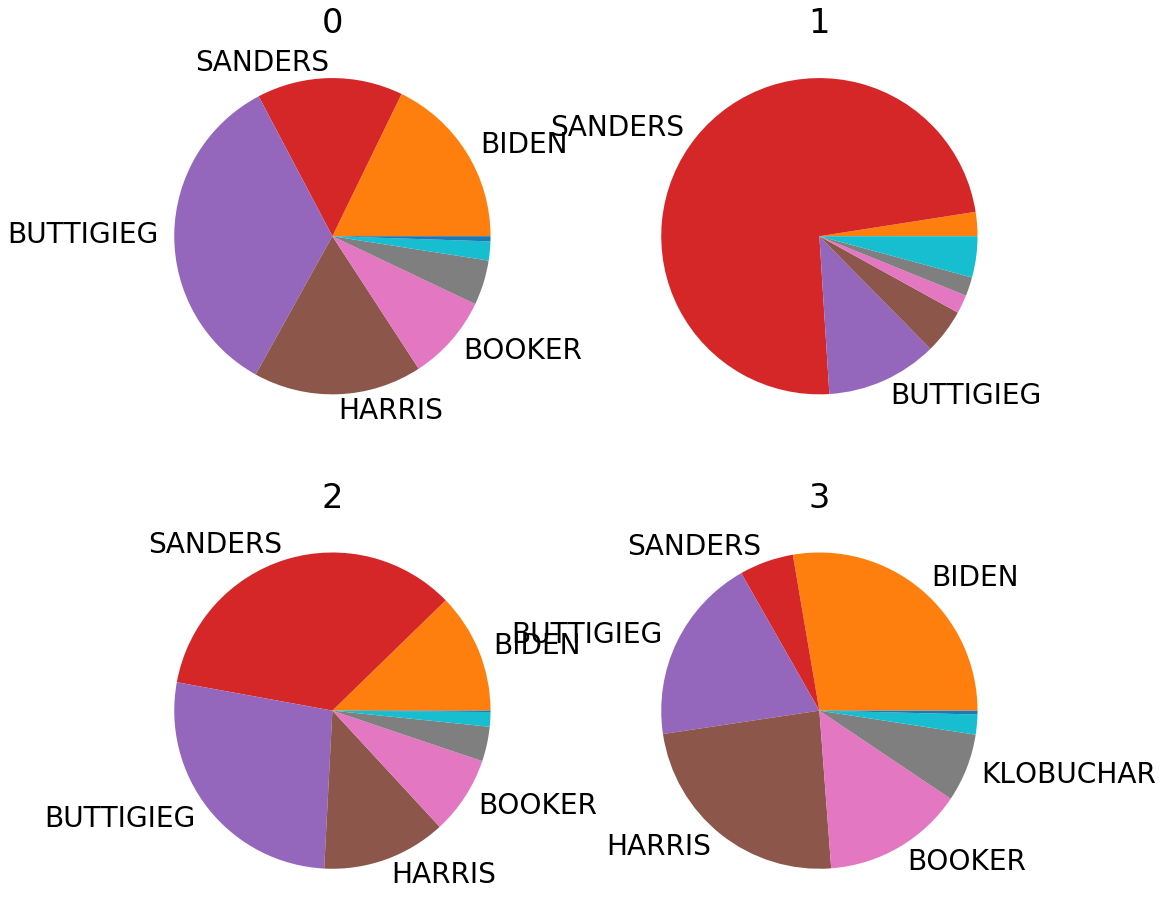

Showing distribution of jobs across clusters


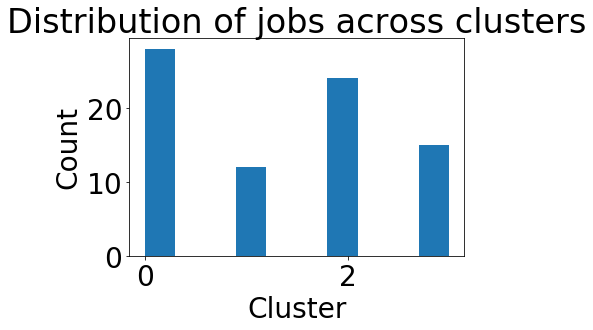

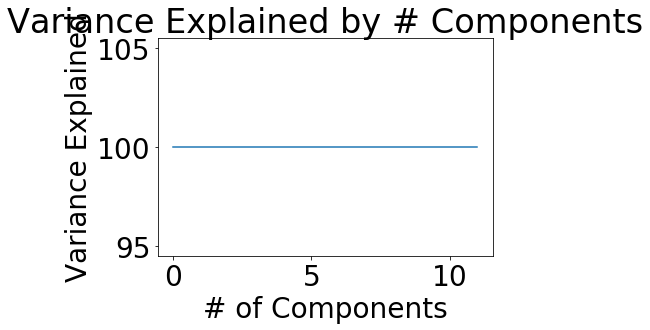

[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]
[0 2 3 1]
NURSE
ELECTRICIAN
PROJECT MANAGER
NONE
ACTOR
ENGINEER
SOFTWARE DEVELOPER
CONSULTANT
PRESIDENT
MANAGER
SELF-EMPLOYED
PROFESSOR
ATTORNEY
HOMEMAKER
REAL ESTATE
CEO
PHYSICIAN
SERVER
PRODUCT MANAGER
SALES
TEACHER
IT
PARTNER
MARKETING
DRIVER
WEB DEVELOPER
STUDENT
ARTIST
EXECUTIVE
NOT EMPLOYED
RETIRED


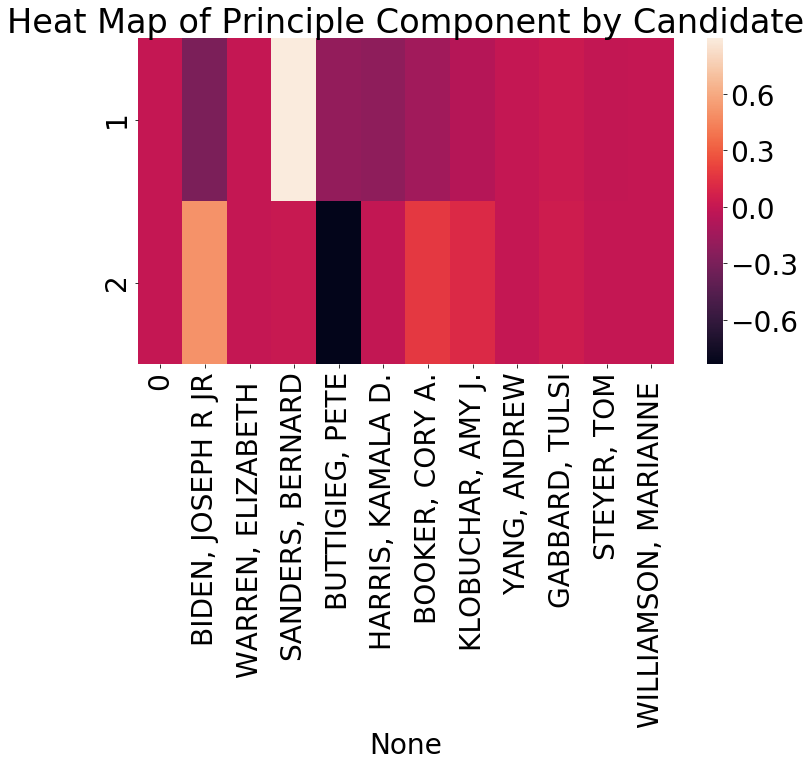

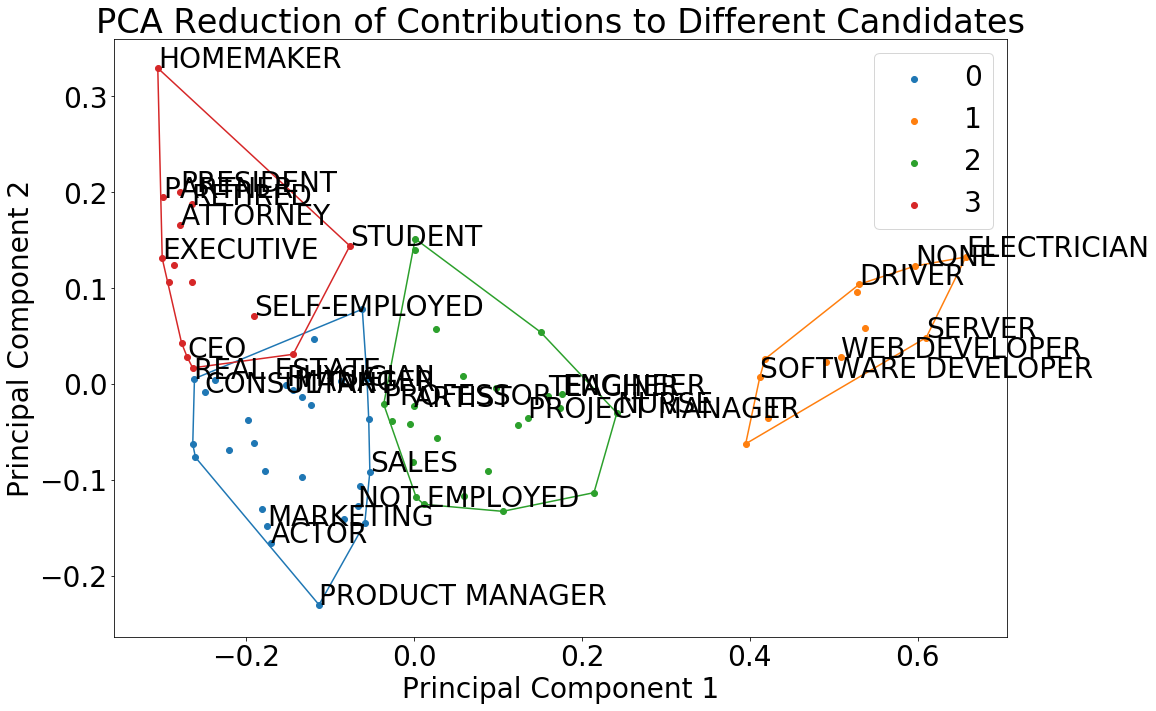

In [12]:
cluster_professions(df)